In [4]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display, Image as IPImage
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)
print("OpenCV version:", cv2.__version__)
print("✓ All libraries imported successfully!")

TensorFlow version: 2.20.0
OpenCV version: 4.12.0
✓ All libraries imported successfully!


In [5]:
cascade_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(cascade_path)
print(f"✓ Face detector loaded from: {cascade_path}")
emotion_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax') 
])

emotion_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

print("\n✓ Emotion Classification Model Architecture:")
emotion_model.summary()

emotion_labels = {
    0: 'Happy',
    1: 'Sad',
    2: 'Neutral'
}

✓ Face detector loaded from: c:\Users\meemz\AppData\Local\Programs\Python\Python310\lib\site-packages\cv2\data\haarcascade_frontalface_default.xml

✓ Emotion Classification Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 318,147 (1.21 MB)

 Trainable params: 318,147 (1.21 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
def detect_faces(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30)
    )
    return faces

def preprocess_face(face_image, target_size=(48, 48)):
    face_resized = cv2.resize(face_image, target_size)
    if len(face_resized.shape) == 3:
        face_resized = cv2.cvtColor(face_resized, cv2.COLOR_BGR2GRAY)
    face_normalized = face_resized.astype('float32') / 255.0
    face_input = np.expand_dims(face_normalized, axis=0)
    face_input = np.expand_dims(face_input, axis=-1)
    
    return face_input

def classify_emotion(image, draw_results=True):
    results = []
    image_copy = image.copy()
    
    # Detect faces
    faces = detect_faces(image)
    
    if len(faces) == 0:
        print("No faces detected in the image")
        return image_copy, []
    
    print(f"Detected {len(faces)} face(s)")
    for (x, y, w, h) in faces:
        face_roi = image_copy[y:y+h, x:x+w]
        face_input = preprocess_face(face_roi)
        predictions = emotion_model.predict(face_input, verbose=0)
        emotion_idx = np.argmax(predictions)
        confidence = predictions[0][emotion_idx]
        emotion_label = emotion_labels[emotion_idx]
        
        results.append({
            'box': (x, y, w, h),
            'emotion': emotion_label,
            'confidence': float(confidence),
            'predictions': {emotion_labels[i]: float(predictions[0][i]) 
                          for i in range(3)}
        })
        if draw_results:
            cv2.rectangle(image_copy, (x, y), (x+w, y+h), (0, 255, 0), 2)
            text = f"{emotion_label} ({confidence:.2%})"
            cv2.putText(image_copy, text, (x, y-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    
    return image_copy, results

print("✓ Classification functions created successfully!")

✓ Classification functions created successfully!


Testing emotion classification on sample image...
Detected 1 face(s)


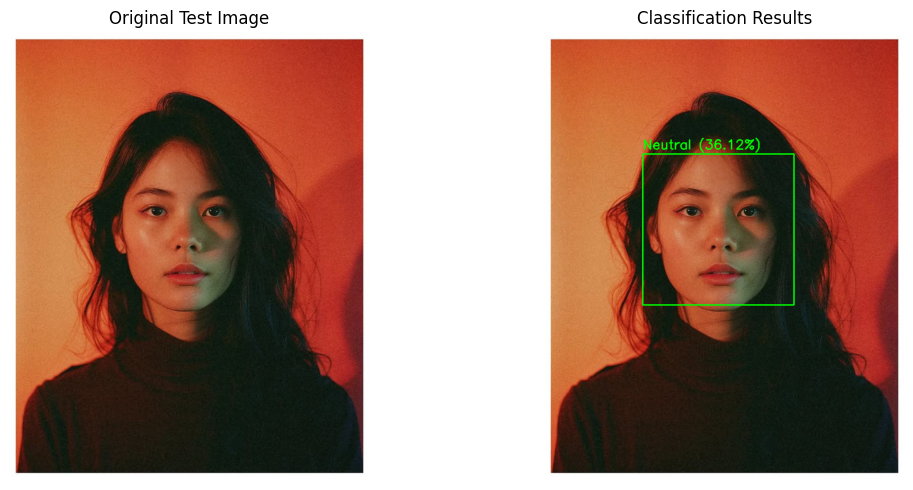


📊 Prediction Results:

Face #1:
  Emotion: Neutral
  Confidence: 36.12%
  All probabilities:
    - Happy: 0.3391
    - Sad: 0.2997
    - Neutral: 0.3612


In [ ]:
test_image=cv2.imread('a.jpg')
print("Testing emotion classification on sample image...")
result_image, predictions = classify_emotion(test_image, draw_results=True)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original Test Image')
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
axes[1].set_title('Classification Results')
axes[1].axis('off')

plt.tight_layout()
plt.show()
if predictions:
    print("\n📊 Prediction Results:")
    for i, pred in enumerate(predictions):
        print(f"\nFace #{i+1}:")
        print(f"  Emotion: {pred['emotion']}")
        print(f"  Confidence: {pred['confidence']:.2%}")
        print(f"  All probabilities:")
        for emotion, prob in pred['predictions'].items():
            print(f"    - {emotion}: {prob:.4f}")
else:
    print("No predictions available (no faces detected in test image)")

In [8]:
def real_time_emotion_detection(num_frames=30, save_screenshot=True):
    cap = cv2.VideoCapture(0)
    
    if not cap.isOpened():
        print("❌ Error: Could not open webcam. Please check if your camera is connected.")
        return
    print("✓ Webcam opened successfully!")
    print("Press 'Q' to quit")
    print("-" * 50)
    
    frame_count = 0
    all_predictions = []
    
    try:
        while True:
            ret, frame = cap.read()
            
            if not ret:
                print("Failed to read frame from webcam")
                break
            frame = cv2.flip(frame, 1)
            result_frame, predictions = classify_emotion(frame, draw_results=True)
            if predictions:
                all_predictions.extend(predictions)
                frame_count += 1
                for pred in predictions:
                    print(f"Frame {frame_count}: {pred['emotion']} ({pred['confidence']:.1%})")
            cv2.imshow('Emotion Classifier - Press Q to Quit', result_frame)
            key = cv2.waitKey(1) & 0xFF
            if key == ord('q') or key == ord('Q'):
                break
            
            if num_frames is not None and frame_count >= num_frames:
                break
    
    finally:
        cap.release()
        cv2.destroyAllWindows()
    
    print("-" * 50)
    print(f"✓ Webcam capture ended. Processed {frame_count} frames")
    
    if all_predictions:
        print("\n📊 Summary of Emotion Detections:")
        emotion_counts = {}
        emotion_confidences = {}
        
        for pred in all_predictions:
            emotion = pred['emotion']
            confidence = pred['confidence']
            
            emotion_counts[emotion] = emotion_counts.get(emotion, 0) + 1
            if emotion not in emotion_confidences:
                emotion_confidences[emotion] = []
            emotion_confidences[emotion].append(confidence)
        
        for emotion in emotion_labels.values():
            count = emotion_counts.get(emotion, 0)
            if count > 0:
                avg_conf = np.mean(emotion_confidences[emotion])
                print(f"  {emotion}: {count} detections (avg confidence: {avg_conf:.2%})")
        
        return all_predictions
    else:
        print("⚠️  No faces detected in any frames")
        return []

print("🎥 Starting real-time emotion detection...\n")
print("⚠️  Note: In a Jupyter notebook, the webcam window may appear in the background.")
print("Make sure to click on the 'Emotion Classifier' window and press 'Q' to quit.\n")

try:
    predictions_list = real_time_emotion_detection(num_frames=None)
except Exception as e:
    print(f"Note: Webcam access may not be available in this environment: {e}")
    print("You can use this code in a regular Python script for full webcam functionality!")

🎥 Starting real-time emotion detection...

⚠️  Note: In a Jupyter notebook, the webcam window may appear in the background.
Make sure to click on the 'Emotion Classifier' window and press 'Q' to quit.

✓ Webcam opened successfully!
Press 'Q' to quit
--------------------------------------------------
No faces detected in the image
No faces detected in the image
No faces detected in the image
No faces detected in the image
No faces detected in the image
No faces detected in the image
No faces detected in the image
No faces detected in the image
No faces detected in the image
No faces detected in the image
No faces detected in the image
No faces detected in the image
No faces detected in the image
No faces detected in the image
No faces detected in the image
No faces detected in the image
No faces detected in the image
No faces detected in the image
No faces detected in the image
No faces detected in the image
No faces detected in the image
No faces detected in the image
No faces detected